<font color = blue><font size = 6> 실험설명 </font></font><br>
Seasonality 한주기를 임의 설정한후 moving average를 주기마다 겹치지 않게 해보겠다(Stride를 조정하겠다는 의미)<br>
여기서는 Linear layer하나에 한개의 trend가 들어가게 된다<br>
이것을 하는 이유는 DLinear에서 Decompose를 할때 moving average 자체에 어느정도의 seasonallity가 포함돼 있는거 같기 때문에 이를 더 엄격하게 구분하기 위해서 이다 <br>
이전에 scaling을 할때 multiplicative method를 사용한 것에 반해
이번에는 Additive method를 사용했다
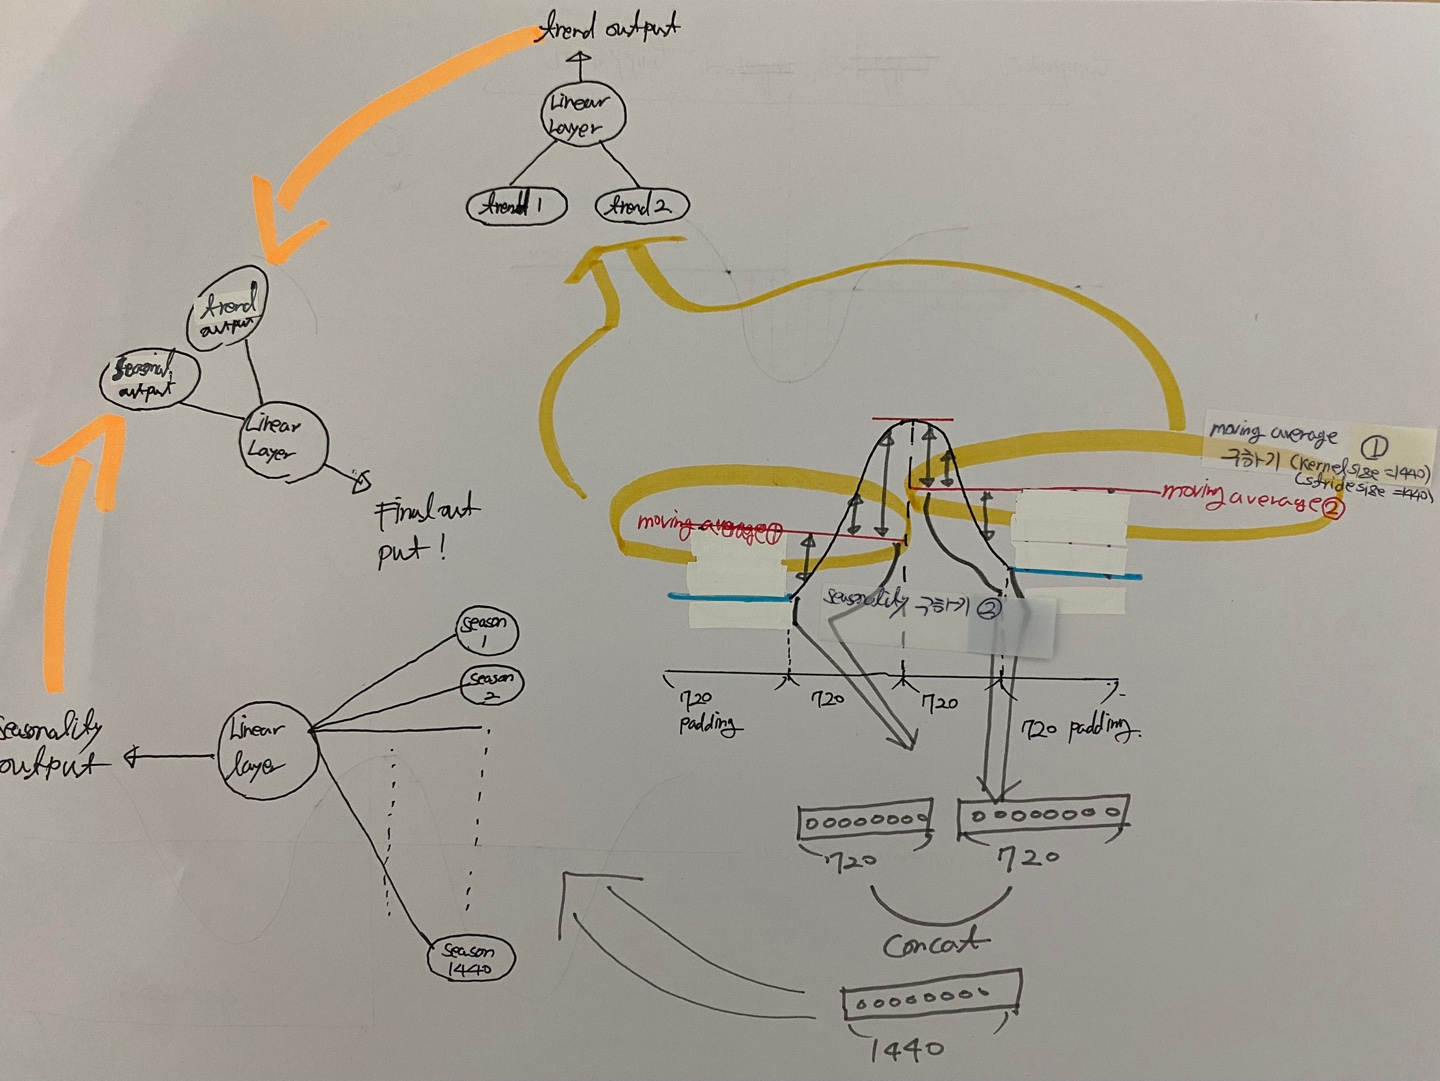

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,MAPE,RMSE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

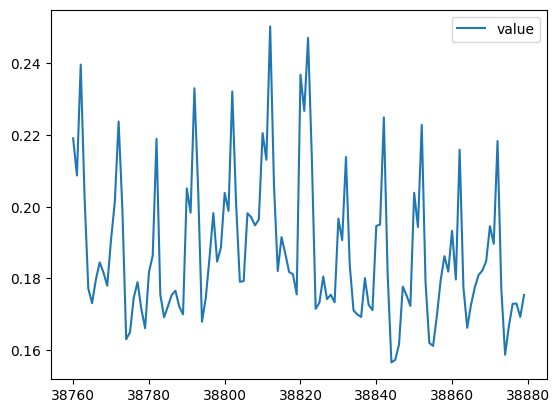

In [6]:
data[-120:].plot()

<AxesSubplot: >

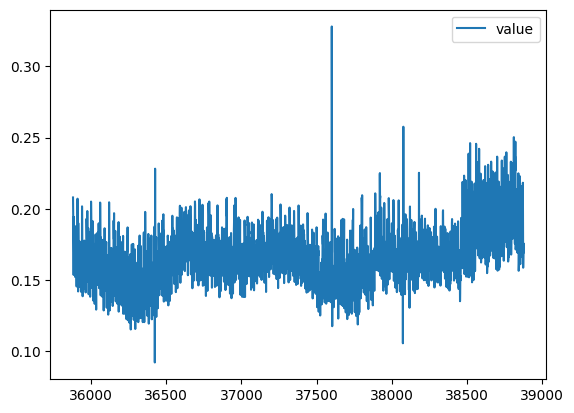

In [4]:
data[-3000:].plot() # 1일의 계절성이 있는것으로 판단된다

<AxesSubplot: >

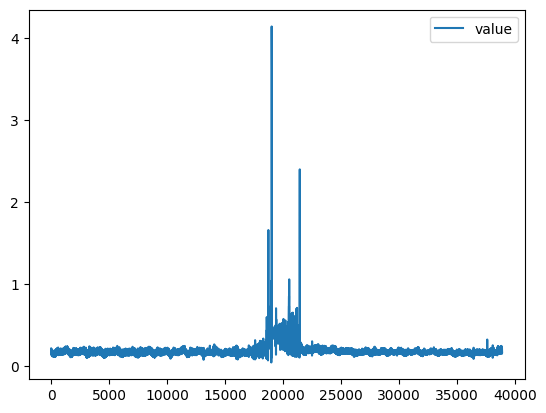

In [5]:
data.plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel2/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))
        
        
        return x

[1,1,1] Size에서 [1,2,1] Size를 빼면 앞에꺼 원소 한개를 뒤에 원소 2개에 대응한다

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size,stride):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size=kernel_size,stride=stride)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        
        moving_mean = moving_mean.permute(0,2,1)
        
        x = x.permute(0,2,1)
        
        res = torch.cat([x[:,:720,:] - moving_mean[:,0:1,:],x[:,720:,:]-moving_mean[:,1:2,:]],dim=1)
        
        # Classical ma중에서 additive model
        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 1440
        self.stride = 1440
        self.decomposition = series_decomp(kernel_size,self.stride)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len//self.stride,self.pred_len)) # 이렇게 설정하면 현재 상황에선 Layer당 Unit이 1개
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(2,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.permute(0,2,1).to(self.device)
        
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_579504/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 16.16189848130558 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 10.143485431782684 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 9.542490173763001 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 9.286284725568448 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 9.169845824614603 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 9.057162027174268 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 9.011299146981964 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 8.94440184124032 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 8.945464164192913 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 8.900711125536272 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 8.915029760254056 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 8.850302852210943 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 8.83870817590178 %
Adjusting lea

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.12455334499207993 %
SMAPE 4.9582568772839295 %
SMAPE 0.2866796274029184 %
SMAPE 0.5491766520568717 %
SMAPE 0.16087729502396542 %
SMAPE 1.8597900073041276 %
SMAPE 1.8861799346013868 %
SMAPE 0.9425726601327823 %
SMAPE 0.4049751316490529 %
SMAPE 0.4103145067142577 %
SMAPE 0.9792217281446938 %
SMAPE 0.9363504689936235 %
SMAPE 0.519109171740979 %
SMAPE 0.7128559700727237 %
SMAPE 0.7600751328664046 %
SMAPE 0.16748234877763934 %
SMAPE 2.716771019038788 %
SMAPE 3.0454404107586015 %
SMAPE 0.0943655718969012 %
SMAPE 1.0544171468845889 %
SMAPE 1.8906826180245844 %
SMAPE 0.5964048549894869 %
SMAPE 0.8961989505005477 %
SMAPE 0.027444503661115505 %
SMAPE 0.7158884228138049 %
SMAPE 3.750225770085308 %
SMAPE 1.0319878026230072 %
SMAPE 0.11865420068352249 %
SMAPE 1.5632112762032195 %
SMAPE 0.15090753625554498 %
SMAPE 0.7462499403409311 %
SMAPE 0.8193378365904209 %
SMAPE 0.37224098640035663 %
SMAPE 0.05547566876884958 %
SMAPE 0.5242489387758269 %
SMAPE 1.911340693182865 %
SMAPE 0.456558732508710

SMAPE 1.3256002728132898 %
SMAPE 0.49748164617994917 %
SMAPE 0.08552973324640334 %
SMAPE 0.7916402484640912 %
SMAPE 0.08173395799531136 %
SMAPE 0.6845288691421274 %
SMAPE 0.21150492135984678 %
SMAPE 0.40151544407899564 %
SMAPE 0.913912695444651 %
SMAPE 1.6802391666951733 %
SMAPE 0.2724060906214163 %
SMAPE 3.201803224050309 %
SMAPE 8.555090736292186 %
SMAPE 4.216668540262617 %
SMAPE 0.14633835985296173 %
SMAPE 1.677373329996044 %
SMAPE 0.665067653965707 %
SMAPE 0.4005835764805852 %
SMAPE 0.5127317166743524 %
SMAPE 1.3732477927578657 %
SMAPE 0.33427909692613866 %
SMAPE 0.06297629571849939 %
SMAPE 0.9007766761292259 %
SMAPE 1.0888029887792072 %
SMAPE 0.14645726506205392 %
SMAPE 2.408201656118763 %
SMAPE 1.0717366136556166 %
SMAPE 0.6133409781731984 %
SMAPE 0.45483981607640095 %
SMAPE 3.304747620786656 %
SMAPE 2.171295001400722 %
SMAPE 0.19095825301337754 %
SMAPE 0.10667645459034247 %
SMAPE 0.13646499084643438 %
SMAPE 0.053285324934904565 %
SMAPE 0.5227063277707202 %
SMAPE 0.17214811657322

SMAPE 0.5908669998248115 %
SMAPE 0.026289555738571835 %
SMAPE 0.32439745304873213 %
SMAPE 0.9607156329780082 %
SMAPE 1.65022282956852 %
SMAPE 1.487510318887871 %
SMAPE 0.034208592278446304 %
SMAPE 0.2348736585254301 %
SMAPE 0.7554496942125297 %
SMAPE 0.08910853449060596 %
SMAPE 0.1386002147141312 %
SMAPE 0.13271564936076174 %
SMAPE 1.4756434136606913 %
SMAPE 0.9332296056709312 %
SMAPE 0.9500932343235036 %
SMAPE 1.5633415740770717 %
SMAPE 0.6465461873867753 %
SMAPE 0.27363577637788694 %
SMAPE 0.1056077824963495 %
SMAPE 0.60976347951555 %
SMAPE 0.11573822971604386 %
SMAPE 1.5215254220038332 %
SMAPE 0.288889757612651 %
SMAPE 1.7320037603349194 %
SMAPE 2.430019472901563 %
SMAPE 0.46442335178016947 %
SMAPE 0.20379629801902865 %
SMAPE 1.6870513373723952 %
SMAPE 1.4984941473630897 %
SMAPE 0.11666708668371939 %
SMAPE 0.7233200711880272 %
SMAPE 0.13304976530207568 %
SMAPE 0.22644901554758687 %
SMAPE 0.8416370368886419 %
SMAPE 0.41538084847115897 %
SMAPE 0.35173247250486384 %
SMAPE 0.91133834522

SMAPE 0.5054945157762631 %
SMAPE 0.06036339958461667 %
SMAPE 0.39524079767613784 %
SMAPE 0.38437786604845314 %
SMAPE 0.7036392387924479 %
SMAPE 0.09475905359886383 %
SMAPE 0.13417718230266473 %
SMAPE 0.38256522165920614 %
SMAPE 0.29318589208332924 %
SMAPE 0.37501553354013595 %
SMAPE 1.0100637061887028 %
SMAPE 1.5089832991279764 %
SMAPE 0.11733920678489085 %
SMAPE 0.33105105473259755 %
SMAPE 0.1078857261545636 %
SMAPE 1.029262121913689 %
SMAPE 0.4704996501152437 %
SMAPE 0.7805994283908149 %
SMAPE 0.1511299501380563 %
SMAPE 0.04103224513164605 %
SMAPE 0.22831337413841626 %
SMAPE 1.1320631927992508 %
SMAPE 0.650975976229347 %
SMAPE 0.38083003565105855 %
SMAPE 0.681828933412362 %
SMAPE 0.654481776544344 %
SMAPE 0.4939161724511223 %
SMAPE 0.8178268302481229 %
SMAPE 0.2327508091041182 %
SMAPE 0.041040643189148795 %
SMAPE 0.027153420759532306 %
SMAPE 0.18096000203149742 %
SMAPE 1.1272218016183615 %
SMAPE 0.0842726626287913 %
SMAPE 0.24596122069476678 %
SMAPE 0.33991471327910006 %
SMAPE 0.3843

SMAPE 1.746692058674398 %
SMAPE 0.12300849025632488 %
SMAPE 0.07284424294084602 %
SMAPE 0.25926846386573743 %
SMAPE 0.040209759543358814 %
SMAPE 1.0437772534667147 %
SMAPE 0.5654493589699996 %
SMAPE 0.36842225311011134 %
SMAPE 0.055056530376532464 %
SMAPE 0.46710117959264613 %
SMAPE 0.07879402394428325 %
SMAPE 0.3901173818085226 %
SMAPE 0.3324237819197151 %
SMAPE 0.4133155083500242 %
SMAPE 1.1538908881248062 %
SMAPE 0.03431544896051264 %
SMAPE 0.3584059300079616 %
SMAPE 0.26492994311593066 %
SMAPE 0.14380262493659757 %
SMAPE 1.1125106292483906 %
SMAPE 0.07413889253029993 %
SMAPE 0.48832186095296487 %
SMAPE 0.43990846831502495 %
SMAPE 0.49331806667851197 %
SMAPE 0.4836080949371535 %
SMAPE 1.27298061781039 %
SMAPE 0.30210338745382614 %
SMAPE 0.05866482117562555 %
SMAPE 0.24242281041153999 %
SMAPE 0.22005628798528679 %
SMAPE 1.2595615638272193 %
SMAPE 0.935509584823194 %
SMAPE 0.24498492765178526 %
SMAPE 0.9544758007332349 %
SMAPE 0.45249202998274995 %
SMAPE 0.04208062149007219 %
SMAPE 0.

SMAPE 0.49473213804003535 %
SMAPE 1.9922262471682188 %
SMAPE 0.6157759663174147 %
SMAPE 0.0326035833145113 %
SMAPE 0.6620535672673213 %
SMAPE 0.029964360442363613 %
SMAPE 0.28667753544232255 %
SMAPE 0.1389767700976563 %
SMAPE 0.1298285636185028 %
SMAPE 0.5797109610543885 %
SMAPE 0.23493607533964675 %
SMAPE 0.1938327252180443 %
SMAPE 0.05045709206842731 %
SMAPE 0.23841261243705958 %
SMAPE 0.08857780826565431 %
SMAPE 0.05933629204037061 %
SMAPE 0.09433641971281759 %
SMAPE 0.027596574238700104 %
SMAPE 0.6325153935849812 %
SMAPE 2.1410992858545796 %
SMAPE 0.08533344011902955 %
SMAPE 0.19910189322945368 %
SMAPE 0.04132908139411029 %
SMAPE 1.1588026225498993 %
SMAPE 0.06761516377537191 %
SMAPE 0.7187645707581396 %
SMAPE 0.07821910672191734 %
SMAPE 1.3746817105384252 %
SMAPE 0.29909535748947746 %
SMAPE 0.8182786934848991 %
SMAPE 0.21522842260719696 %
SMAPE 0.09915299493331986 %
SMAPE 0.050657098704050434 %
SMAPE 0.5459141884366545 %
SMAPE 0.5842964306229987 %
SMAPE 0.5305020112209604 %
SMAPE 

SMAPE 0.38415777686464025 %
SMAPE 0.10624700269907095 %
SMAPE 0.5631694328176309 %
SMAPE 0.6021655596831863 %
SMAPE 0.2620447860601871 %
SMAPE 1.7517807126259868 %
SMAPE 0.03353703189679891 %
SMAPE 0.6775561941559545 %
SMAPE 0.0746223154693837 %
SMAPE 0.5158388318559446 %
SMAPE 1.1377040056613623 %
SMAPE 0.8778603440978259 %
SMAPE 0.46325283286228114 %
SMAPE 0.9480662637952265 %
SMAPE 0.31764038910114323 %
SMAPE 0.3725827990997459 %
SMAPE 0.30398796992540156 %
SMAPE 0.3503285786603101 %
SMAPE 0.882606547745354 %
SMAPE 0.33585774004905034 %
SMAPE 0.1069368741082144 %
SMAPE 0.35395372009224957 %
SMAPE 0.6292242520376021 %
SMAPE 2.1327619195899388 %
SMAPE 0.1675694727427981 %
SMAPE 0.16186160946399042 %
SMAPE 0.13910363708237128 %
SMAPE 15.11941496655345 %
SMAPE 4.030937338320655 %
SMAPE 4.2442114879613655 %
SMAPE 2.5519691683471137 %
SMAPE 1.385332315127016 %
SMAPE 0.29371663985602936 %
SMAPE 0.24343745977193973 %
SMAPE 0.05507122268124931 %
SMAPE 0.066333714297798 %
SMAPE 0.556098431057

SMAPE 0.07111928001398837 %
SMAPE 0.4708323403870054 %
SMAPE 0.44516464890637053 %
SMAPE 0.889961132698545 %
SMAPE 0.4156652719393606 %
SMAPE 0.48583674245992364 %
SMAPE 0.31579418216051636 %
SMAPE 0.4704230566649131 %
SMAPE 1.0964059984997903 %
SMAPE 0.4118045941377204 %
SMAPE 1.5492860721137731 %
SMAPE 0.22516997463617375 %
SMAPE 3.3810040661210223 %
SMAPE 1.7959783071164568 %
SMAPE 1.479406260883934 %
SMAPE 0.2283251708577154 %
SMAPE 0.4792966035081463 %
SMAPE 0.43861837971599016 %
SMAPE 0.4180076161801481 %
SMAPE 0.22371477594947461 %
SMAPE 0.34864812655814603 %
SMAPE 0.24629679885038055 %
SMAPE 0.6909369671839158 %
SMAPE 0.9048952251653191 %
SMAPE 1.2145370109601572 %
SMAPE 0.45782743053132435 %
SMAPE 0.5904448373539708 %
SMAPE 0.08605974982947373 %
SMAPE 0.0417522398871597 %
SMAPE 0.792869234729551 %
SMAPE 0.4169268241762438 %
SMAPE 0.04145163846783362 %
SMAPE 0.04064407307123474 %
SMAPE 0.4179938760244113 %
SMAPE 0.09582306682023045 %
SMAPE 0.9693960888616857 %
SMAPE 0.364661763

SMAPE 0.07339634551271956 %
SMAPE 0.718357366618875 %
SMAPE 0.7420316031038965 %
SMAPE 0.4383305108541435 %
SMAPE 0.2099910479164464 %
SMAPE 0.4597385561528427 %
SMAPE 0.1218566480665686 %
SMAPE 0.12013374963589742 %
SMAPE 0.2689881176211202 %
SMAPE 0.04498668942073891 %
SMAPE 0.06366942794511488 %
SMAPE 7.206763828842668 %
SMAPE 0.9190674687451973 %
SMAPE 0.12404077759128995 %
SMAPE 0.12483139608411875 %
SMAPE 1.47792525501427 %
SMAPE 2.2444480043141084 %
SMAPE 1.2417129468594794 %
SMAPE 1.8067350246237766 %
SMAPE 0.41005022117593626 %
SMAPE 0.6126749700561049 %
SMAPE 1.867447695580722 %
SMAPE 0.13177907622412022 %
SMAPE 1.5747117321270705 %
SMAPE 0.7370098034289185 %
SMAPE 0.3201754346755479 %
SMAPE 0.6921331296500739 %
SMAPE 0.8187681247777618 %
SMAPE 1.0883354727802725 %
SMAPE 0.18155051290227675 %
SMAPE 1.4989379502803786 %
SMAPE 1.444192599536109 %
SMAPE 2.1202498349157395 %
SMAPE 0.6967045334149589 %
SMAPE 0.36648938785162954 %
SMAPE 0.19890360474346377 %
SMAPE 0.112847234705782

SMAPE 0.03400462199516596 %
SMAPE 0.126825407839533 %
SMAPE 0.23800247726103407 %
SMAPE 1.154206062805315 %
SMAPE 0.17076512518224263 %
SMAPE 0.0417121728719394 %
SMAPE 0.36704050314568804 %
SMAPE 0.6370225660002689 %
SMAPE 0.08920250964320076 %
SMAPE 1.7751448608960343 %
SMAPE 0.0651863530351875 %
SMAPE 1.0606951726313127 %
SMAPE 0.6762913676973312 %
SMAPE 0.4836955314567603 %
SMAPE 1.0842408504086052 %
SMAPE 1.038115455339721 %
SMAPE 0.12999022823919404 %
SMAPE 0.06917456025439606 %
SMAPE 0.633041038522606 %
SMAPE 0.12162367210629556 %
SMAPE 0.14577437748530997 %
SMAPE 0.800605264283149 %
SMAPE 1.2015772785107401 %
SMAPE 0.5781713831531761 %
SMAPE 1.7523098421297618 %
SMAPE 0.5039930926795932 %
SMAPE 0.14061967954046395 %
SMAPE 1.0337953417692916 %
SMAPE 0.4805029302192451 %
SMAPE 0.1257960730333707 %
SMAPE 0.8652358219087546 %
SMAPE 1.0040346510686504 %
SMAPE 0.6031360838500177 %
SMAPE 0.04474916632534587 %
SMAPE 0.6554603231707006 %
SMAPE 0.04131898703963088 %
SMAPE 0.2703826364468

SMAPE 0.3012801486606804 %
SMAPE 0.3272762695137317 %
SMAPE 6.683232611743733 %
SMAPE 1.6068845176960167 %
SMAPE 0.1490869189190107 %
SMAPE 3.3607622002164135 %
SMAPE 0.28996846220394445 %
SMAPE 0.7663347074931153 %
SMAPE 0.16813481924464213 %
SMAPE 0.8417389566293423 %
SMAPE 1.9014560922441888 %
SMAPE 0.11346322400277133 %
SMAPE 3.1796816420010146 %
SMAPE 0.04430473946285929 %
SMAPE 0.042916617296668846 %
SMAPE 1.6172585460735718 %
SMAPE 0.04711969312461406 %
SMAPE 0.7255755131191108 %
SMAPE 1.1183148126365268 %
SMAPE 0.33402143914599947 %
SMAPE 0.46840687900521516 %
SMAPE 1.3174138080248667 %
SMAPE 2.608690288698199 %
SMAPE 0.018467452029199194 %
SMAPE 1.1266289791119561 %
SMAPE 0.03281971475519185 %
SMAPE 0.4922216407558153 %
SMAPE 1.1229259316146454 %
SMAPE 0.8621239918211359 %
SMAPE 0.4341279591635612 %
SMAPE 0.03310632235866251 %
SMAPE 0.6556351578192334 %
SMAPE 1.2392891974445774 %
SMAPE 0.629421533220011 %
SMAPE 0.3705364308971184 %
SMAPE 0.29857639722899876 %
SMAPE 0.139637830

SMAPE 0.7383081852876785 %
SMAPE 0.4230955980340241 %
SMAPE 0.4662462133746885 %
SMAPE 1.3537583114120935 %
SMAPE 0.376395130315359 %
SMAPE 0.8405927676521969 %
SMAPE 0.19752422099486464 %
SMAPE 1.836826891896635 %
SMAPE 1.9341562653280562 %
SMAPE 0.4107473332451264 %
SMAPE 0.7422813151391665 %
SMAPE 1.2007672987369915 %
SMAPE 0.172126449872394 %
SMAPE 0.8841051744329889 %
SMAPE 0.29159896113824857 %
SMAPE 2.029931134034996 %
SMAPE 0.3138017409310123 %
SMAPE 0.9625520851302553 %
SMAPE 0.235181892790024 %
SMAPE 2.2229738868136337 %
SMAPE 0.16721345460427983 %
SMAPE 1.209305174936162 %
SMAPE 0.6547947227664963 %
SMAPE 1.6075296524322764 %
SMAPE 0.6373104704334764 %
SMAPE 0.923568837069979 %
SMAPE 1.7086480697980733 %
SMAPE 1.4129515826462011 %
SMAPE 0.22940925184775554 %
SMAPE 0.19228521776312846 %
SMAPE 0.45130532363134535 %
SMAPE 0.30605133905123694 %
SMAPE 0.2820261373944959 %
SMAPE 1.2588429199440725 %
SMAPE 0.6109203984506166 %
SMAPE 2.337479037436424 %
SMAPE 0.15847851772741706 %
S

SMAPE 0.17840147759125102 %
SMAPE 0.13581376449292293 %
SMAPE 1.0545216726768558 %
SMAPE 4.506118371267803 %
SMAPE 0.09127513379280572 %
SMAPE 2.0995621653937633 %
SMAPE 0.2983816929998966 %
SMAPE 0.05200592529217829 %
SMAPE 1.1287468814916792 %
SMAPE 0.12991671270538063 %
SMAPE 1.2199080646096263 %
SMAPE 0.061006880379864015 %
SMAPE 0.18264537223490152 %
SMAPE 1.2791872931029502 %
SMAPE 0.44965305123423605 %
SMAPE 0.9224136272423492 %
SMAPE 0.057949406548004845 %
SMAPE 0.08007645043107914 %
SMAPE 0.11019806987883383 %
SMAPE 0.41070608101836115 %
SMAPE 0.02495683061869158 %
SMAPE 0.5838583527142873 %
SMAPE 3.123744867123605 %
SMAPE 0.3979260910355152 %
SMAPE 2.0492830175753625 %
SMAPE 0.8496256366706803 %
SMAPE 2.1115327671909654 %
SMAPE 0.09486645785545988 %
SMAPE 1.9336113954332177 %
SMAPE 0.2667469435552903 %
SMAPE 0.4066733568579366 %
SMAPE 0.336845020601686 %
SMAPE 0.15822535963889095 %
SMAPE 0.1105254318513289 %
SMAPE 0.52533821988618 %
SMAPE 0.10010098740349349 %
SMAPE 0.6694673

SMAPE 0.10924371325745598 %
SMAPE 0.08377257341271616 %
SMAPE 0.6944421823409357 %
SMAPE 3.4216652979102946 %
SMAPE 2.1473972035892075 %
SMAPE 0.18370180405418068 %
SMAPE 1.5370590483908018 %
SMAPE 0.024393020589968728 %
SMAPE 0.12131830892576545 %
SMAPE 0.16010580397414742 %
SMAPE 0.0329834508543172 %
SMAPE 2.057036065630257 %
SMAPE 0.16727199949673377 %
SMAPE 0.933926194695232 %
SMAPE 1.0598344027212079 %
SMAPE 0.4837935426230615 %
SMAPE 0.0733181221689847 %
SMAPE 0.42567450426210485 %
SMAPE 0.04330138461267552 %
SMAPE 0.2660614848323348 %
SMAPE 0.2929687931682565 %
SMAPE 0.12468318806372736 %
SMAPE 0.4552151771858917 %
SMAPE 0.1638644482163727 %
SMAPE 0.18302379261143642 %
SMAPE 0.39586687137443727 %
SMAPE 0.7296245767020082 %
SMAPE 0.2541350848248385 %
SMAPE 0.6790675309330254 %
SMAPE 0.04765277865004691 %
SMAPE 0.2927766431580494 %
SMAPE 0.055472812835432705 %
SMAPE 0.026500350317149923 %
SMAPE 0.20298674069135814 %
SMAPE 0.1376253578671367 %
SMAPE 0.5625099789849628 %
SMAPE 0.783

SMAPE 2.6891305964891217 %
SMAPE 0.2868085813970538 %
SMAPE 0.17338864603152615 %
SMAPE 0.09264075166970542 %
SMAPE 0.6940761700091116 %
SMAPE 0.48182169786923623 %
SMAPE 2.460223240486812 %
SMAPE 0.04512001647526631 %
SMAPE 0.12520285015079935 %
SMAPE 0.7016245712256932 %
SMAPE 0.39722112696971124 %
SMAPE 0.37860010536223854 %
SMAPE 1.0332205726508619 %
SMAPE 0.5728638212021906 %
SMAPE 0.09770958675278507 %
SMAPE 0.014205867660280092 %
SMAPE 0.2650153214981401 %
SMAPE 0.11483633325337905 %
SMAPE 0.6453360222724314 %
SMAPE 0.02041749251748115 %
SMAPE 0.365129629582043 %
SMAPE 0.6630145050478404 %
SMAPE 0.007059732743641689 %
SMAPE 0.7476187184984155 %
SMAPE 0.4409593817913446 %
SMAPE 0.2811520980367277 %
SMAPE 0.9650713140072185 %
SMAPE 0.793985699505356 %
SMAPE 0.3344308304212973 %
SMAPE 0.0202355737347375 %
SMAPE 0.895359225802622 %
SMAPE 0.19264031502299872 %
SMAPE 0.3880281713941258 %
SMAPE 1.2235649523518077 %
SMAPE 0.5759191180150083 %
SMAPE 2.962059217308706 %
SMAPE 0.2595091260

SMAPE 2.364069607631791 %
SMAPE 3.7180707742390946 %
SMAPE 0.23182367603180862 %
SMAPE 5.843251761922147 %
SMAPE 0.25240701080474537 %
SMAPE 0.03210058429704077 %
SMAPE 5.407721051305998 %
SMAPE 0.08663844035936563 %
SMAPE 0.2085346922667668 %
SMAPE 2.681652600003872 %
SMAPE 1.882260197571668 %
SMAPE 0.04635151917534586 %
SMAPE 0.1130618970555588 %
SMAPE 0.3980572101172583 %
SMAPE 0.5301694886929909 %
SMAPE 0.2226585876860554 %
SMAPE 0.5615083180975944 %
SMAPE 0.174424704350713 %
SMAPE 3.269593701683334 %
SMAPE 0.3144985874417898 %
SMAPE 0.22052353007461534 %
SMAPE 1.120563292888619 %
SMAPE 0.23496933155274746 %
SMAPE 0.08660602000804829 %
SMAPE 0.4257350081172717 %
SMAPE 0.08420370562097901 %
SMAPE 1.1130605632497463 %
SMAPE 0.8011637106694707 %
SMAPE 0.6079910272865163 %
SMAPE 0.18393786379988342 %
SMAPE 1.3249131831580598 %
SMAPE 2.8757406145044797 %
SMAPE 0.5781631168474632 %
SMAPE 0.19112701125550302 %
SMAPE 2.0071058946248286 %
SMAPE 6.3775758470001165 %
SMAPE 0.01493398079401231

SMAPE 1.48079131308441 %
SMAPE 1.1059834045706793 %
SMAPE 1.3707241464217077 %
SMAPE 0.3910659554724134 %
SMAPE 0.17116519120327212 %
SMAPE 0.41342594235493385 %
SMAPE 0.13364867245354617 %
SMAPE 0.41321721657641314 %
SMAPE 1.8566791460980312 %
SMAPE 0.1287514115152817 %
SMAPE 0.22194136610265502 %
SMAPE 0.029400856353049676 %
SMAPE 0.28720328889528446 %
SMAPE 0.0193172953729146 %
SMAPE 0.09229189381608194 %
SMAPE 0.5704240786544688 %
SMAPE 0.36961319732381526 %
SMAPE 0.4535977648561129 %
SMAPE 0.5221548001436531 %
SMAPE 0.055698451866192045 %
SMAPE 0.020201862849603458 %
SMAPE 0.44153334285715573 %
SMAPE 0.42647070210546195 %
SMAPE 0.24991485702798855 %
SMAPE 0.29386051687788495 %
SMAPE 0.5594585221974739 %
SMAPE 1.0060417100230552 %
SMAPE 10.879737086594105 %
SMAPE 1.030819574144516 %
SMAPE 0.397543712979882 %
SMAPE 0.49912558259575235 %
SMAPE 1.2845857061474817 %
SMAPE 0.9401542458872427 %
SMAPE 1.6512164478081106 %
SMAPE 0.22564249082597598 %
SMAPE 0.6192542998885529 %
SMAPE 0.5163

SMAPE 1.1847256978021505 %
SMAPE 0.1176854286050002 %
SMAPE 0.3608559832987339 %
SMAPE 0.11076646276069368 %
SMAPE 0.13827535666359836 %
SMAPE 0.4355088360925947 %
SMAPE 1.1298795186116877 %
SMAPE 1.6782202728081757 %
SMAPE 0.17430446905473218 %
SMAPE 0.07468720536928686 %
SMAPE 0.31351033607506906 %
SMAPE 0.22466664201357386 %
SMAPE 0.4476705671706895 %
SMAPE 0.13665007787312788 %
SMAPE 0.5806679326033191 %
SMAPE 2.1190894652995667 %
SMAPE 0.5674097680075647 %
SMAPE 0.6677895039283612 %
SMAPE 0.2735334080859957 %
SMAPE 1.023407955552102 %
SMAPE 1.344856804538722 %
SMAPE 0.8282703337335988 %
SMAPE 0.04201576358559578 %
SMAPE 0.2224050185386659 %
SMAPE 1.1518345044605667 %
SMAPE 0.03532039459787484 %
SMAPE 0.31650287332740845 %
SMAPE 0.4230650837889698 %
SMAPE 0.5553117711092455 %
SMAPE 2.846257382450858 %
SMAPE 0.09877384612764217 %
SMAPE 0.06602271882002242 %
SMAPE 0.15705281777485425 %
SMAPE 1.0444485331911437 %
SMAPE 0.8745871482060465 %
SMAPE 2.2200562741059002 %
SMAPE 0.0876422068

SMAPE 0.17407990055835398 %
SMAPE 1.4268219571586087 %
SMAPE 1.0355462098486896 %
SMAPE 2.8314105377958185 %
SMAPE 0.3676295776676852 %
SMAPE 0.754181865902865 %
SMAPE 0.5024039811332841 %
SMAPE 0.08201343444989107 %
SMAPE 0.7472655943511199 %
SMAPE 0.06898553138398711 %
SMAPE 0.18274147080956027 %
SMAPE 0.280148343646033 %
SMAPE 3.472647447852069 %
SMAPE 1.0471532507744996 %
SMAPE 0.5664970864897896 %
SMAPE 0.23246462776296536 %
SMAPE 0.2758177934019841 %
SMAPE 0.19750916331622648 %
SMAPE 0.3361415784502242 %
SMAPE 0.8470042755798204 %
SMAPE 0.7813600035296986 %
SMAPE 0.03689743336018125 %
SMAPE 0.10276901842098596 %
SMAPE 0.6221528374003356 %
SMAPE 1.3971144533006736 %
SMAPE 0.6464248387947009 %
SMAPE 0.03721627096997793 %
SMAPE 1.1051240027991298 %
SMAPE 0.40262814255947893 %
SMAPE 1.8563745496030606 %
SMAPE 1.0927396788110855 %
SMAPE 1.519280652288444 %
SMAPE 2.9883133340172208 %
SMAPE 0.5595571087733333 %
SMAPE 0.03497386349624776 %
SMAPE 0.391726229559481 %
SMAPE 0.03183135173094

SMAPE 0.3549002833678969 %
SMAPE 0.34852010570921266 %
SMAPE 4.938459604166383 %
SMAPE 0.056600258448042944 %
SMAPE 0.22390544526865597 %
SMAPE 2.9337441498209955 %
SMAPE 0.40695584147306363 %
SMAPE 0.21940691795998643 %
SMAPE 6.352006294415332 %
SMAPE 0.2922587929358542 %
SMAPE 0.6110947869283336 %
SMAPE 1.4077548122295411 %
SMAPE 0.04390836191026892 %
SMAPE 0.083764181659717 %
SMAPE 0.6628677303742734 %
SMAPE 1.0156561407966365 %
SMAPE 0.44623603634045145 %
SMAPE 1.927687695100758 %
SMAPE 0.1429270372796907 %
SMAPE 0.06559096048385982 %
SMAPE 1.279352638655837 %
SMAPE 0.2490579015338881 %
SMAPE 2.2497831211512676 %
SMAPE 0.15000810041783552 %
SMAPE 0.2917571825323648 %
SMAPE 0.17092553563679758 %
SMAPE 0.16350281080849527 %
SMAPE 0.0807566524053982 %
SMAPE 1.0090639280897449 %
SMAPE 0.06328287264841492 %
SMAPE 1.4568426521727815 %
SMAPE 0.5940760599423811 %
SMAPE 0.05642134498066298 %
SMAPE 0.6284659153971006 %
SMAPE 0.2581845211896905 %
SMAPE 0.5060979351844423 %
SMAPE 0.05823703343

SMAPE 0.13643930204125354 %
SMAPE 0.8437322343070264 %
SMAPE 5.6889986615860835 %
SMAPE 4.695038745798229 %
SMAPE 0.9046078392148047 %
SMAPE 1.4482831376408285 %
SMAPE 0.38318870424700435 %
SMAPE 0.7906694704706752 %
SMAPE 0.4983874181801866 %
SMAPE 0.49413621923895334 %
SMAPE 0.9023141328962083 %
SMAPE 0.6690456494548016 %
SMAPE 0.17152969500602921 %
SMAPE 6.55126269813627 %
SMAPE 1.959378040075535 %
SMAPE 0.8828023569781179 %
SMAPE 1.9766324643405824 %
SMAPE 0.1408224367226012 %
SMAPE 0.4642529867487611 %
SMAPE 2.027856634636919 %
SMAPE 0.24834834109424261 %
SMAPE 0.2762595314764553 %
SMAPE 0.03580177814956187 %
SMAPE 3.402779829713836 %
SMAPE 2.760611688128847 %
SMAPE 0.037794178913827636 %
SMAPE 0.3335465759382714 %
SMAPE 0.08312012973874516 %
SMAPE 1.7214785674273116 %
SMAPE 0.15219799501210218 %
SMAPE 1.478776530835603 %
SMAPE 0.4183596412258339 %
SMAPE 0.2579396346482099 %
SMAPE 1.1998673006082754 %
SMAPE 0.9806608776748361 %
SMAPE 1.1660174998096409 %
SMAPE 0.41000394124716877 

SMAPE 5.708918927990453 %
SMAPE 4.4004401552228956 %
SMAPE 0.640040597186271 %
SMAPE 2.4932513613066476 %
SMAPE 1.2703063410226605 %
SMAPE 0.11004954669806466 %
SMAPE 0.03049340273719281 %
SMAPE 4.016582335680141 %
SMAPE 0.5081989413738484 %
SMAPE 0.3252540040266467 %
SMAPE 0.34127707382049266 %
SMAPE 1.5427866298714434 %
SMAPE 4.8115402760740835 %
SMAPE 0.06756534683199789 %
SMAPE 0.2858945774341919 %
SMAPE 0.0746168828629834 %
SMAPE 0.06953065091511235 %
SMAPE 0.9084230625176134 %
SMAPE 0.6229269840205234 %
SMAPE 0.5458526762504334 %
SMAPE 4.09136941748875 %
SMAPE 0.0402207778945467 %
SMAPE 0.40073035509703914 %
SMAPE 1.580500657290031 %
SMAPE 0.25676124442907167 %
SMAPE 0.04582258510708925 %
SMAPE 1.9215254357832237 %
SMAPE 0.12459532203823187 %
SMAPE 0.5013881627273804 %
SMAPE 0.6658389031244951 %
SMAPE 1.8520099285487959 %
SMAPE 0.4559439690051476 %
SMAPE 1.005038937743393 %
SMAPE 0.14616225249847048 %
SMAPE 0.47938442436679907 %
SMAPE 1.1504434879129803 %
SMAPE 0.2088368252243526

SMAPE 0.32338074088465874 %
SMAPE 1.5444014416498248 %
SMAPE 0.13277667231682244 %
SMAPE 1.223839911180221 %
SMAPE 0.01267841110984591 %
SMAPE 1.8252495940942026 %
SMAPE 0.05620672785335046 %
SMAPE 2.64665607427105 %
SMAPE 0.21481128716459352 %
SMAPE 1.2711189335441304 %
SMAPE 0.10646461834997467 %
SMAPE 2.9142557793109063 %
SMAPE 0.2299429833356044 %
SMAPE 1.0208702443815127 %
SMAPE 6.123486558091827 %
SMAPE 1.1832148704415886 %
SMAPE 1.1047936041350113 %
SMAPE 1.1086664191052478 %
SMAPE 0.13033183190100317 %
SMAPE 3.494459748835652 %
SMAPE 0.06250262743924395 %
SMAPE 0.6778100274423196 %
SMAPE 6.314177299122094 %
SMAPE 0.6104289057864207 %
SMAPE 0.4702044888945238 %
SMAPE 1.8045131922699509 %
SMAPE 1.6440219534379141 %
SMAPE 0.496408681907269 %
SMAPE 0.3023088175978046 %
SMAPE 0.03782303981461155 %
SMAPE 3.845275138991383 %
SMAPE 0.4372732204124077 %
SMAPE 2.0063939322935767 %
SMAPE 0.0663226865182196 %
SMAPE 0.40298753112074337 %
SMAPE 0.0394209600844988 %
SMAPE 0.5094834683789884 %

SMAPE 1.5288880210794105 %
SMAPE 0.5887743597951385 %
SMAPE 1.883945181274612 %
SMAPE 1.6477487416186705 %
SMAPE 0.31060512906265103 %
SMAPE 3.678389005028294 %
SMAPE 1.986925705408794 %
SMAPE 0.35839610066000205 %
SMAPE 0.4183045403151482 %
SMAPE 0.2276741176174255 %
SMAPE 2.5547027121319843 %
SMAPE 1.252031602338434 %
SMAPE 0.05766535922953153 %
SMAPE 3.064911657202174 %
SMAPE 1.6675515887109214 %
SMAPE 0.11085860305220764 %
SMAPE 0.9253729591316642 %
SMAPE 0.4151180898898019 %
SMAPE 0.06679798918958113 %
SMAPE 0.08961173368516029 %
SMAPE 0.8669745810002495 %
SMAPE 0.029012612730184628 %
SMAPE 0.050514351247329614 %
SMAPE 0.036499809516953974 %
SMAPE 0.8149096854958771 %
SMAPE 0.18378427008792642 %
SMAPE 1.2576397721604735 %
SMAPE 0.35722717416592786 %
SMAPE 1.9180273372762715 %
SMAPE 0.4734473115859146 %
SMAPE 0.43072156521611765 %
SMAPE 0.20257554346062534 %
SMAPE 0.7669349111008614 %
SMAPE 3.5288938077574135 %
SMAPE 1.5839217952006948 %
SMAPE 0.04361119746727127 %
SMAPE 0.48268361

SMAPE 1.4722796609457873 %
SMAPE 0.15649358839209526 %
SMAPE 0.823598885206593 %
SMAPE 0.6385805336572616 %
SMAPE 0.02307028614600881 %
SMAPE 0.02477546323461866 %
SMAPE 0.03205227441100078 %
SMAPE 1.1395819015488087 %
SMAPE 0.2980729433220404 %
SMAPE 0.07210169123391097 %
SMAPE 0.9312109655511449 %
SMAPE 0.049448288416101605 %
SMAPE 0.8300568792255945 %
SMAPE 0.59700584031566 %
SMAPE 0.20014642535761598 %
SMAPE 1.1389101604972893 %
SMAPE 1.9977271281677529 %
SMAPE 1.223802570130374 %
SMAPE 0.4108105739319967 %
SMAPE 0.17552988510215073 %
SMAPE 0.13742455154920208 %
SMAPE 0.032203631560150825 %
SMAPE 0.2852712536287072 %
SMAPE 2.1027459758215628 %
SMAPE 0.010780293734796942 %
SMAPE 0.3880974706935376 %
SMAPE 0.04465049070313398 %
SMAPE 0.4656904060975648 %
SMAPE 0.45760807746592036 %
SMAPE 0.3837539158148502 %
SMAPE 0.39283050621043 %
SMAPE 0.26053651908461006 %
SMAPE 0.9410200680940761 %
SMAPE 0.027169465092356404 %
SMAPE 0.2396184025600405 %
SMAPE 0.14767617947791223 %
SMAPE 0.376821

SMAPE 4.6347711424095905 %
SMAPE 1.9147996773535851 %
SMAPE 1.207693366024614 %
SMAPE 3.831066289974842 %
SMAPE 0.9126200614050504 %
SMAPE 0.9648748461877403 %
SMAPE 1.6310519291873788 %
SMAPE 0.12138548603616074 %
SMAPE 0.6787411919763144 %
SMAPE 0.28178565047369375 %
SMAPE 0.5121722139024314 %
SMAPE 6.0038315930032695 %
SMAPE 0.28731076667077105 %
SMAPE 1.1673722415580414 %
SMAPE 0.3423863201983295 %
SMAPE 1.2179985026914437 %
SMAPE 2.8214083877910525 %
SMAPE 3.1177898315418133 %
SMAPE 1.049743462819606 %
SMAPE 1.8261061201756092 %
SMAPE 0.08767498348970548 %
SMAPE 0.04295197057399491 %
SMAPE 2.2385126724329893 %
SMAPE 7.075049042701721 %
SMAPE 3.0748589396316675 %
SMAPE 6.993099709507078 %
SMAPE 0.523661410470595 %
SMAPE 0.4889678338709586 %
SMAPE 0.5891419067470451 %
SMAPE 2.15622381029425 %
SMAPE 0.5734191361448211 %
SMAPE 0.5074284636157245 %
SMAPE 1.316427761169507 %
SMAPE 0.7658027724719432 %
SMAPE 1.934583808440948 %
SMAPE 0.5307607265673369 %
SMAPE 0.032410109302873025 %
SMAP

SMAPE 0.1162533620676598 %
SMAPE 0.36917937716316374 %
SMAPE 0.6709459698395221 %
SMAPE 1.441017295464917 %
SMAPE 0.23095851941161527 %
SMAPE 0.5864581964092395 %
SMAPE 0.9946356279882593 %
SMAPE 0.5786075332404153 %
SMAPE 0.12978132758823335 %
SMAPE 0.03974782362723772 %
SMAPE 0.6270122148976043 %
SMAPE 0.17538755171335652 %
SMAPE 0.07185485656373203 %
SMAPE 0.19148008793069948 %
SMAPE 1.494120051342179 %
SMAPE 1.1415734211259405 %
SMAPE 0.13716279502841644 %
SMAPE 0.2771015750378183 %
SMAPE 0.42246137405936685 %
SMAPE 0.12761076251337045 %
SMAPE 0.09534107811987269 %
SMAPE 0.0530619806534105 %
SMAPE 1.5918267823908534 %
SMAPE 0.19223638203038718 %
SMAPE 0.7329751363640753 %
SMAPE 0.7153728173125273 %
SMAPE 0.20168969147016466 %
SMAPE 1.7061352876153248 %
SMAPE 0.408736603133093 %
SMAPE 0.07803306639198127 %
SMAPE 0.8017768547833839 %
SMAPE 0.02036225798110536 %
SMAPE 0.1950723768690068 %
SMAPE 0.04435760405408473 %
SMAPE 0.9679954171501778 %
SMAPE 0.1947222684912049 %
SMAPE 0.4807873

SMAPE 2.017520185550893 %
SMAPE 0.016179952959589627 %
SMAPE 0.8269906836558221 %
SMAPE 0.07018927710578282 %
SMAPE 0.017279106795001553 %
SMAPE 0.3953308247384939 %
SMAPE 0.23186348186027317 %
SMAPE 0.0457803540376176 %
SMAPE 0.14288359774764103 %
SMAPE 0.5351568810160643 %
SMAPE 0.15543823825191794 %
SMAPE 0.6847276672901899 %
SMAPE 0.3120663258590639 %
SMAPE 0.015103671039923938 %
SMAPE 0.15341828640384847 %
SMAPE 0.36715508395786856 %
SMAPE 1.5353533312409127 %
SMAPE 0.20910721281506994 %
SMAPE 0.07170931280279547 %
SMAPE 8.675103679299355 %
SMAPE 2.0791005651071828 %
SMAPE 1.2094667925684917 %
SMAPE 0.3324515982119891 %
SMAPE 0.013276553600917397 %
SMAPE 0.8356802203525148 %
SMAPE 1.1401347844403062 %
SMAPE 0.08177202133674655 %
SMAPE 0.6723369077026291 %
SMAPE 1.0186937362650497 %
SMAPE 0.45863060638112074 %
SMAPE 1.213813966579437 %
SMAPE 0.25928023048072646 %
SMAPE 0.9406922676099612 %
SMAPE 0.2037825037315315 %
SMAPE 0.19889390633829862 %
SMAPE 1.174671685505018 %
SMAPE 1.3679

SMAPE 0.05164777724530722 %
SMAPE 0.026750591132440604 %
SMAPE 0.27214112254569045 %
SMAPE 10.619155082851648 %
SMAPE 0.6161514998536859 %
SMAPE 3.505488593094924 %
SMAPE 0.043893482777434656 %
SMAPE 1.5914032282089465 %
SMAPE 1.2392017309903167 %
SMAPE 0.2633769676567681 %
SMAPE 0.5106948258180637 %
SMAPE 1.4835576894802216 %
SMAPE 0.4164719671717876 %
SMAPE 0.5531544150730952 %
SMAPE 0.10413457696090234 %
SMAPE 0.654685038706134 %
SMAPE 0.19598394798458685 %
SMAPE 0.19896956391221463 %
SMAPE 0.11924775340480663 %
SMAPE 0.03521869787346077 %
SMAPE 0.8707433022118494 %
SMAPE 0.2535513768907549 %
SMAPE 0.3485708811617769 %
SMAPE 0.040769379995253985 %
SMAPE 1.2341649459666542 %
SMAPE 0.6427604229843382 %
SMAPE 1.3200315824069548 %
SMAPE 0.06877815107432639 %
SMAPE 0.13346571381487138 %
SMAPE 0.4477231508105888 %
SMAPE 0.19570756977464043 %
SMAPE 0.1770239030051357 %
SMAPE 0.344317502051922 %
SMAPE 0.27551688269886654 %
SMAPE 0.16896005079343013 %
SMAPE 0.7904736987898104 %
SMAPE 0.83512

SMAPE 1.0909236192637763 %
SMAPE 1.1775415147985768 %
SMAPE 1.2115144831368525 %
SMAPE 6.5911450795829305 %
SMAPE 4.027940404310357 %
SMAPE 0.0568740335484108 %
SMAPE 8.79750419035554 %
SMAPE 6.88297306964887 %
SMAPE 0.6650632455784944 %
SMAPE 0.029641806607713757 %
SMAPE 0.9402979661263088 %
SMAPE 6.662681360729039 %
SMAPE 1.255686331907782 %
SMAPE 0.28840895420944435 %
SMAPE 0.48559414546980406 %
SMAPE 0.08205497610379098 %
SMAPE 2.391988638154544 %
SMAPE 2.9442162355389883 %
SMAPE 0.27488055216963403 %
SMAPE 0.1796340791345301 %
SMAPE 0.6026887497528151 %
SMAPE 1.693363185175258 %
SMAPE 0.6151373405609775 %
SMAPE 4.599654992882279 %
SMAPE 1.5054967147880234 %
SMAPE 0.2586634136716839 %
SMAPE 0.21212072388561864 %
SMAPE 0.33611736435636885 %
SMAPE 1.8814850824369387 %
SMAPE 0.9255031134271121 %
SMAPE 0.36939800710479176 %
SMAPE 1.0435815036639724 %
SMAPE 0.2942199350250121 %
SMAPE 0.08097499734446956 %
SMAPE 4.082162986829644 %
SMAPE 1.57054974652965 %
SMAPE 6.481546599417926 %
SMAPE

SMAPE 0.7376376624322916 %
SMAPE 0.26862505312658413 %
SMAPE 0.06592291026345265 %
SMAPE 1.280920409598238 %
SMAPE 1.0752130081536961 %
SMAPE 0.021163199027569135 %
SMAPE 0.027976598626992196 %
SMAPE 1.27756053636449 %
SMAPE 2.0413606520756957 %
SMAPE 2.6829010959099833 %
SMAPE 1.3156411809504789 %
SMAPE 0.060447152587471464 %
SMAPE 0.07068005248267184 %
SMAPE 0.053652910198707104 %
SMAPE 2.712815517801573 %
SMAPE 0.22623622986884584 %
SMAPE 0.040340282581610154 %
SMAPE 0.013953223266099712 %
SMAPE 4.486767046808382 %
SMAPE 0.6221765903646883 %
SMAPE 1.5077086297713578 %
SMAPE 0.055045873048584326 %
SMAPE 1.477575708850054 %
SMAPE 2.263212879490311 %
SMAPE 0.7405537392660335 %
SMAPE 0.03245083297952078 %
SMAPE 0.21614755941368455 %
SMAPE 0.7182588346785792 %
SMAPE 0.7033861156069179 %
SMAPE 0.03144876004307662 %
SMAPE 2.0074403648577572 %
SMAPE 0.029659495814222225 %
SMAPE 0.8357078193221241 %
SMAPE 0.9847118766256244 %
SMAPE 0.17341949846831994 %
SMAPE 1.0715041598668904 %
SMAPE 2.872

SMAPE 0.1940292860590489 %
SMAPE 0.3205898413916657 %
SMAPE 0.18334815431200013 %
SMAPE 0.09833037328826322 %
SMAPE 0.5823545720795664 %
SMAPE 0.024825046344631122 %
SMAPE 5.898728746338747 %
SMAPE 2.385995691511198 %
SMAPE 0.10705881826470433 %
SMAPE 1.7456335673196008 %
SMAPE 0.010558587048308254 %
SMAPE 0.7752298778959812 %
SMAPE 3.9795174001483247 %
SMAPE 0.5525537607463775 %
SMAPE 1.7920109999804483 %
SMAPE 0.9478563443262829 %
SMAPE 0.7614410371675149 %
SMAPE 3.6067983437897055 %
SMAPE 1.7387079494537832 %
SMAPE 0.23352532868383943 %
SMAPE 0.35541968422057835 %
SMAPE 0.01444167463523627 %
SMAPE 0.47587147862395796 %
SMAPE 0.030627077027929772 %
SMAPE 0.29259053873647645 %
SMAPE 0.20184862860105568 %
SMAPE 0.06421991308826591 %
SMAPE 0.1612378465842994 %
SMAPE 0.4438796676056427 %
SMAPE 0.35439430185988385 %
SMAPE 1.5566607087894226 %
SMAPE 0.08530758584674913 %
SMAPE 1.127395942734438 %
SMAPE 1.3676045977472313 %
SMAPE 3.021503072377527 %
SMAPE 0.14856303098304124 %
SMAPE 1.26020

SMAPE 1.286616402700929 %
SMAPE 0.11615047544364643 %
SMAPE 7.455206726677716 %
SMAPE 0.28829135214937196 %
SMAPE 6.660152125172317 %
SMAPE 0.7065311358561814 %
SMAPE 0.8392896096829645 %
SMAPE 4.409257026563864 %
SMAPE 1.173625558767526 %
SMAPE 0.7739288471511827 %
SMAPE 1.3454211501798454 %
SMAPE 0.2532521649463888 %
SMAPE 3.2949072763876757 %
SMAPE 0.6883169228422048 %
SMAPE 0.11003264014652814 %
SMAPE 0.9164193335509481 %
SMAPE 2.948000521530048 %
SMAPE 1.7922720288661365 %
SMAPE 2.5503901424090145 %
SMAPE 1.463307403064391 %
SMAPE 0.7177952923884732 %
SMAPE 14.167563781142235 %
SMAPE 1.7698666092828714 %
SMAPE 2.4014132844822598 %
SMAPE 0.1999409674142498 %
SMAPE 0.8140929558862808 %
SMAPE 2.697499585628975 %
SMAPE 4.435467303504993 %
SMAPE 17.36769211292267 %
SMAPE 2.0480317295277928 %
SMAPE 0.10692857804724554 %
SMAPE 0.15017892629509788 %
SMAPE 2.2557202244533983 %
SMAPE 0.562396616100159 %
SMAPE 0.9449278693909945 %
SMAPE 0.11446023082635293 %
SMAPE 1.486759226756476 %
SMAPE 1

SMAPE 0.7798034989873486 %
SMAPE 0.12004815254886125 %
SMAPE 0.11356182869985787 %
SMAPE 0.9554708799832952 %
SMAPE 1.0659607427596711 %
SMAPE 4.131021499575581 %
SMAPE 6.7726397551596165 %
SMAPE 0.07762507522420492 %
SMAPE 2.0907753012470494 %
SMAPE 0.5776825540718846 %
SMAPE 0.33283454830575465 %
SMAPE 0.11209081737513316 %
SMAPE 0.1721745623372044 %
SMAPE 1.2402445059342426 %
SMAPE 0.5440847951772412 %
SMAPE 4.673042755057395 %
SMAPE 4.178701144293882 %
SMAPE 0.4356802750780844 %
SMAPE 0.08231760878402383 %
SMAPE 0.6694093309963023 %
SMAPE 0.04057764446906731 %
SMAPE 0.6618695329962065 %
SMAPE 0.8948615852623333 %
SMAPE 0.19121557471771666 %
SMAPE 0.13442281578866755 %
SMAPE 1.3948219959165726 %
SMAPE 0.7393344274762512 %
SMAPE 1.1456660633157298 %
SMAPE 1.0820355850082706 %
SMAPE 1.5290120525569364 %
SMAPE 1.930488999823865 %
SMAPE 0.32337929803151155 %
SMAPE 0.15962883416250406 %
SMAPE 0.11108817977628858 %
SMAPE 2.2163896121310245 %
SMAPE 3.0337385670209187 %
SMAPE 1.650324103941

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.1738528311252594,
 0.1979645937681198,
 0.18882599472999573,
 0.18341870605945587,
 0.17301106452941895,
 0.184401735663414,
 0.1715727299451828,
 0.18696229159832,
 0.1782923936843872,
 0.18585871160030365,
 0.19455386698246002,
 0.19060687720775604,
 0.1796806901693344,
 0.18526333570480347,
 0.17524008452892303,
 0.17113953828811646,
 0.17035479843616486,
 0.1599346101284027,
 0.15137137472629547,
 0.16418832540512085,
 0.17749935388565063,
 0.16789588332176208,
 0.15439379215240479,
 0.16509127616882324,
 0.14897297322750092,
 0.15477757155895233,
 0.15578246116638184,
 0.1655750274658203,
 0.14927002787590027,
 0.1394198089838028,
 0.17489860951900482,
 0.15660986304283142,
 0.15762434899806976,
 0.16851159930229187,
 0.1572507917881012,
 0.15076912939548492,
 0.1490238606929779,
 0.1595507264137268,
 0.15884651243686676,
 0.1536448746919632,
 0.18756867945194244,
 0.17470960319042206,
 0.17766958475112915,
 0.19561155140399933,
 0.16705234348773956,
 0.15250781178474426,
 0.16

In [19]:
target=list(target.values.reshape(-1))

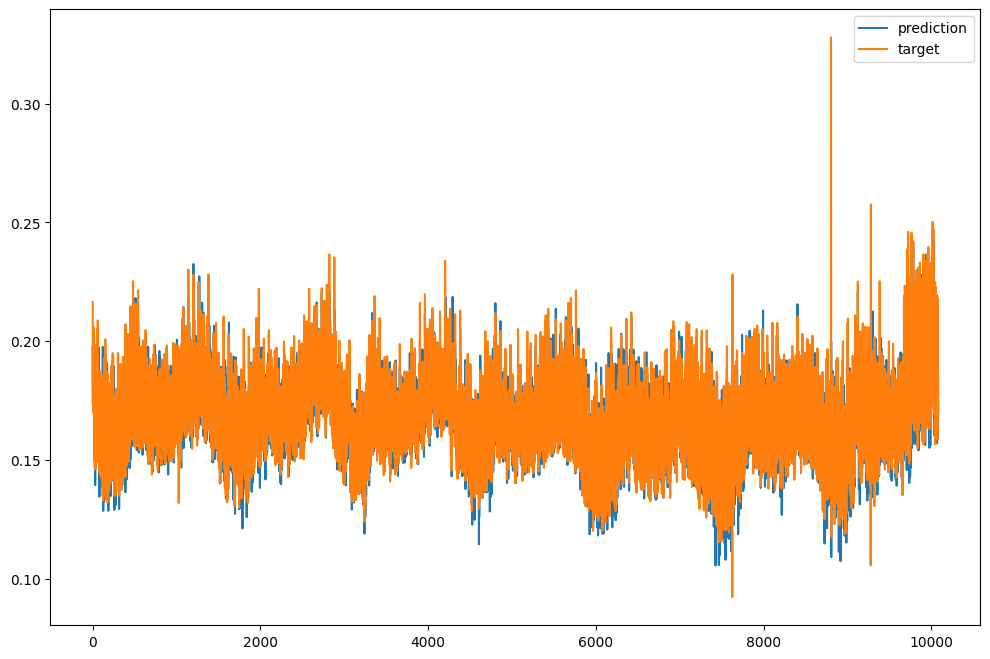

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.17385283, 0.19796459, 0.18882599, ..., 0.18566377, 0.18012346,
       0.17760761])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [31]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 3.5534892231225967 %
RMSE 0.008194678463041782
MAPE 3.5511910915374756 %


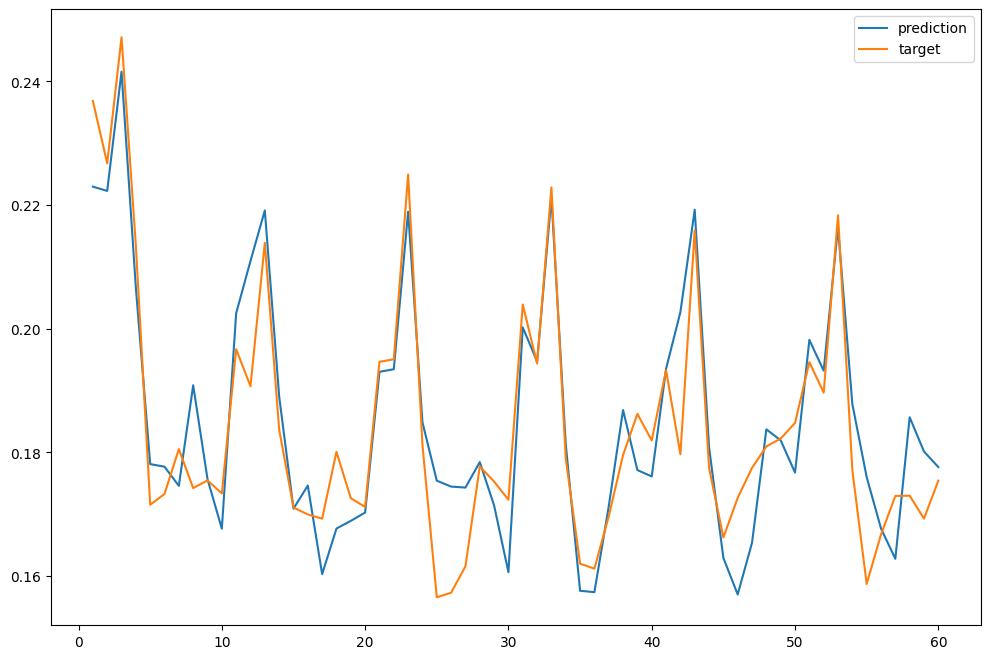

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

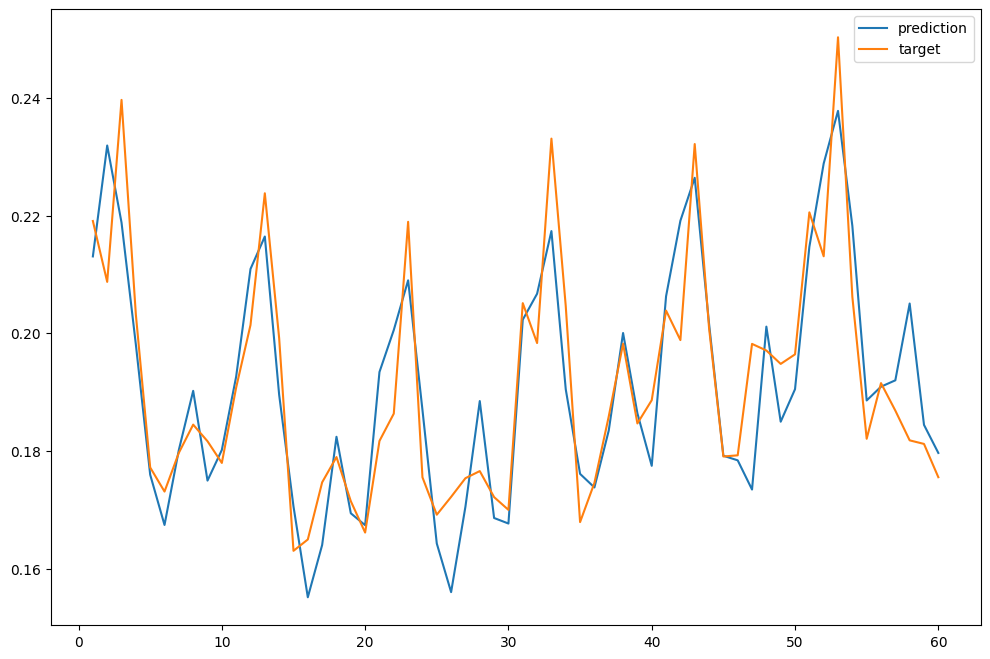

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

In [27]:
len(time_list)

10080

In [28]:
np.mean(time_list) 

0.4328330542123507

FIRST